AI Programming - SW Lee

# Lab 07: Tabular Q Learning
## Exercise: Frozen Lake, Taxi

### Prepare Library Packages

In [59]:
# Check if this code runs in Colab
RunningInCOLAB = 'google.colab' in str(get_ipython())

# Installing the required library and Import tqdm for notebook if Colab
if RunningInCOLAB:
    !pip install gymnasium
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

In [60]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import wrappers

In [61]:
# Check the installed version
gym.__version__

'1.0.0'

### Select Environment

**Frozen Lake**<br>
https://gymnasium.farama.org/environments/toy_text/frozen_lake/


**Taxi**<br>
https://gymnasium.farama.org/environments/toy_text/taxi/

**Blackjack**<br>
https://gymnasium.farama.org/environments/toy_text/blackjack/

In [62]:
# select evironment
# Text Game: 0 for FrozenLake 4x4, 1 for Taxi, 2 for Blackjack

SELECT_ENV = 2 # Choose the environment

In [63]:
# Frozen Lake configuration settings
if SELECT_ENV == 0:
    env_name, res_prefix = 'FrozenLake-v1', 'lak4'           # Environment name and result file prefix
    max_episodes, max_ep_steps, goal_score = 3000, 500, 0.8  # Number of learning episodes, maximum steps per episode and goal score
    val_ep_num, lr_rate, discount_rate = 20, 0.8, 0.95       # Number of evaluation episodes, learning rate, discount rate
# Taxi configuration settings
elif SELECT_ENV == 1:
    env_name, res_prefix = 'Taxi-v3', 'taxi'
    max_episodes, max_ep_steps, goal_score = 1000, 500, 8.0
    val_ep_num, lr_rate, discount_rate = 20, 0.8, 0.95
# Blackjack configuration settings
elif SELECT_ENV == 2:
    env_name, res_prefix = 'Blackjack-v1', 'blkj'
    max_episodes, max_ep_steps, goal_score = 5000, 10, -0.05
    val_ep_num, lr_rate, discount_rate = 1000, 0.1, 0.95
# Error in invalid selection
else: assert False, 'environment selection error'

# Create a Gym environment to the selected environment
def create_env():
    if   SELECT_ENV == 0:   # Create Forzen Lake Environment
        env = gym.make(env_name, desc=None, map_name='4x4', is_slippery=True, render_mode='rgb_array')
    elif   SELECT_ENV == 1: # Create Taxi Environment
        env = gym.make(env_name, render_mode='rgb_array')
    elif   SELECT_ENV == 2: # Create Blackjack Environment
        env = gym.make(env_name, natural=False, sab=False, render_mode='rgb_array')
    else: pass              # Do not process incorrect choices
    return env

In [64]:
# Environmental Initialization Function
def env_reset(env):
    observation = env.reset() # Initialize the environment and bring in initial observations
    obs = observation[0] if type(observation)==tuple else observation # Use the first value if the observation is a tuple
    if SELECT_ENV == 2: # In a Blackjack environment
        state = obs[0] + 32 * obs[2] + 64 * obs[1] # State calculation
    else: state = obs   # Use as is in other environments
    return state

# One-step execution function in the environment
def env_step(env, action):
    observation = env.step(action) # Use a given action to take a step forward in environment
    if SELECT_ENV == 2:
        state = observation[0][0] + 32 * observation[0][2] + 64 * observation[0][1]
    else: state = observation[0]
    reward = observation[1] # Get rewards
    done = observation[2] or observation[3] if len(observation)>4 else observation[2] # Determininig whether to done
    return state, reward, done

In [65]:
env = create_env() # Call function that creates environment
state = env_reset(env) # Initialize the environment and get the initial state
state, reward, done = env_step(env, env.action_space.sample()) # Select a random action and apply it to the environment to receive a new condition, reward, done

### Check and Show Environment Variables

In [66]:
# Check the action space type and set corresponding parameters
action_shape = env.action_space.shape
action_space_type = type(env.action_space)

# For Discrete action space
if action_space_type==gym.spaces.discrete.Discrete:
    actn_space = 'DISCRETE'
    action_shape = (1,)
    action_dims = 1
    action_range = env.action_space.n
    num_actions = action_range  # number of actions is action range for DISCRETE actions
    action_batch_shape = (None, action_range)
# For Continuous action space
elif action_space_type==gym.spaces.box.Box:
    actn_space = 'CONTINUOUS'
    action_dims = action_shape[0]
    actn_uppr_bound = env.action_space.high[0]
    actn_lowr_bound = env.action_space.low[0]
    action_range = (actn_uppr_bound - actn_lowr_bound) # x0.5 for tanh output
    action_batch_shape = tuple([None]+[x for x in action_shape])
    num_actions = action_dims   # number of actions is action dimension for CONTINUOUS actions
# If neither is the case
else: assert False, 'other action space type are not supported'

# Check the observation space type and set corresponding parameters
observation_space_type = type(env.observation_space)
observation_shape = env.observation_space.shape

# For Discrete observation space
if observation_space_type==gym.spaces.discrete.Discrete:
    observation_shape = (1,)
    num_states = env.observation_space.n
# For Box (continuous) observation space
elif observation_space_type==gym.spaces.box.Box:
    num_states = observation_shape[0]
# For Tuple observation space (e.g., multiple spaces combined)
elif observation_space_type==gym.spaces.tuple.Tuple:
    observation_shape = tuple([x.n for x in env.observation_space])
    num_states = np.prod(observation_shape)
# Unsupported
else: print('observation space type error')

# Define state shape and batch shape depending on environment
if SELECT_ENV == 2:
    state_shape = (1,)
    state_batch_shape = (None,1)
else:
    state_shape = observation_shape
    state_batch_shape = tuple([None]+[x for x in observation_shape])

# Set value shape
value_shape = (1,)
num_values = 1

In [67]:
# Prints action space, shape, dimensions, range, max/min values, batch shape,
# observation space, shape, state size, state shape, batch shape, and value dimensions
print('Action space ', action_space_type)
print('Action shape ', action_shape)
print('Action dimensions ', action_dims)
print('Action range ', action_range)
if action_space_type==gym.spaces.box.Box:
    print('Max Value of Action ', actn_uppr_bound)
    print('Min Value of Action ', actn_lowr_bound)
else: pass
print('Action batch shape ', action_batch_shape)

print('Observation space ', observation_space_type)
print('Observation shape ', observation_shape)
print('Size of State Space ', num_states)
print('State shape ', state_shape)
print('State batch shape ', state_batch_shape)

print('Vallue shape ', value_shape)
print('Value dimensions ', num_values)

Action space  <class 'gymnasium.spaces.discrete.Discrete'>
Action shape  (1,)
Action dimensions  1
Action range  2
Action batch shape  (None, 2)
Observation space  <class 'gymnasium.spaces.tuple.Tuple'>
Observation shape  (32, 11, 2)
Size of State Space  704
State shape  (1,)
State batch shape  (None, 1)
Vallue shape  (1,)
Value dimensions  1


### Define and Initialize The Agent
### **Exercise:** Define Q-table (Numpy)

In [68]:
### START CODE HERE ###

Q_table = np.zeros((num_states, num_actions)) # Q-table initialized with zeros based on the number of states and actions

###  END CODE HERE  ###

print(Q_table.shape)

(704, 2)


### Define and Initialize Hyperparameters

In [69]:
total_episodes = max_episodes   # Total episodes
max_steps = max_ep_steps        # Max steps per episode
learning_rate = lr_rate         # Learning rate
gamma = discount_rate           # Discounting rate
val_episodes = val_ep_num       # Number of validation episodes

### Define Epsilon Function

This is an example of exponential decay epsilon function. One of easist epsilon decay functions is simply to multiply 0.9. You can define your own epsilon function.

In [70]:
# Exploration parameters for epsilon greedy strategy
class Epsilon:
    def __init__(self, max_steps):
        self.explore_start = 1.0            # Initial exploration probability at start
        self.explore_stop = 0.01            # Minimum exploration probability
        self.decay_rate = 20.0/max_steps    # Exponential decay rate for reducing exploration prob (4.6 ~ max_step = 0.01)
        self.steps = 0                      # Counter to track the number of steps taken

    def get_epsilon(self):
        # Calculate the current exploration probability using exponential decay formula
        eps = (self.explore_stop
            + (self.explore_start - self.explore_stop) * np.exp(-self.decay_rate * self.steps))
        self.steps += 1                     # Increment the step counter
        return eps                          # Return the current exploration probability

### Learning Procedures

Q-learning is an off-policy TD control algorithm.

$$ Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha (r_{t} + \gamma \max_{a} Q(s_{t+1},a) - Q(s_t,a_t) ) $$

The target policy $\pi$ is greedy w.r.t. $Q(s,a)$

$$ \pi (s_{t}) = \arg \max_{a^\prime} Q(s_{t},a^\prime) $$

### **Exercise:** Define Training Loop and Evaluation Loop

In [71]:
def evaluate_policy(env, qtable, num_average, images=None):

    total_reward = 0.0               # Accumulates total reward over all evaluation episodes
    total_steps = 0                  # Accumulates total steps taken across episodes
    episodes_to_play = num_average   # Number of episodes to play for evaluation
    for _ in range(episodes_to_play):  # Play n episode and calculate average performance
        state = env_reset(env)         # Reset the environment to its initial state
        if images!=None: images.append(env.render()) # If images is provided, capture the environment's initial render
        done = False  # Track whether the episode is finished
        episode_reward = 0.0  # Accumulates reward for the current episode
        while not done:  # Continue until the episode is finished

            ### START CODE HERE ###

            action = np.argmax(qtable[state])                     # Select the best action from the Q-table for the current state
            next_state, reward, done = env_step(env, action)      # Take action and observe the next state, reward, and done flag

            ###  END CODE HERE  ###

            if images!=None: images.append(env.render()) # If images is provided, capture the environment's render after each step
            state = next_state                          # Update current state to the next state
            episode_reward += reward                    # Accumulate the reward for this episode
            total_steps += 1                            # Increment the total step count
        total_reward += episode_reward                  # Add the episode's reward to the total reward
    average_reward = total_reward / episodes_to_play    # Take the average reward of evaluations
    average_steps = total_steps / episodes_to_play      # Take the average steps of evaluations

    return average_reward, average_steps, images        # Return the averages and images


In [72]:
history = {'rewards' : []}                          # Dictionary to logs of rewards
epsF = Epsilon(total_episodes)                      # Generate epsilon object for epsilon-greedy strategy

# Create a progress bar
pbar = tqdm(range(total_episodes), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')

for episodes in pbar: # Iterate through all episodes

    # initialize variables for a new episode
    epis_rewards = 0                                # Total rewards accumulated in episode
    epis_steps = 0                                  # Total steps token in episode
    done = False                                    # Episode end flag

    state = env_reset(env)                          # Reset the environment to the initial state

    epsilon = epsF.get_epsilon()                    # Get the current epsilon value for exploration

    while not done:                                 # Simulate until the terminal state of the episode

        ### START CODE HERE ###

        # Get a random number for exploration decision
        random_number = np.random.rand()
        # If random number > greater than epsilon --> exploitation
        if random_number > epsilon:
            #  Find an index of the biggest Q value for this state
            action = np.argmax(Q_table[state])
         # Else doing a random choice --> exploration
        else:
            #  Get a random integer in [0,action_range)
            action = np.random.randint(0, action_range)

        # Take the action to environment and observe the next state, reward, and done flag
        next_state, reward, done = env_step(env, action)
        # Update Q-table using Q-learning update rule
        Q_table[state, action] += learning_rate * (reward + gamma * np.max(Q_table[next_state] - Q_table[state, action]))


        ###  END CODE HERE  ###

        epis_rewards += reward                      # Accumulate rewards to calculate the episode reward
        state = next_state                          # Set state for the next state

        if epis_steps > max_steps: break            # Terminate if the episode exceeds the maximum steps
        else: epis_steps += 1                       # Increment step count

    # Evaluate the policy after each episode
    eval_reward, eval_steps, _ = evaluate_policy(env, Q_table, val_episodes) # Evaluate the policy

    history['rewards'].append(eval_reward) # Log the evaluation reward

    pbar.set_postfix({'reward':eval_reward, 'steps':eval_steps}) # Update progress bar

    if eval_reward>goal_score: break                # Exit if convergence

print('episodes:{0:5d}, final_reward {1:4.2f}'.format(episodes, eval_reward))

  0%|          | 0/5000 [00:00<?, ?it/s]

episodes:  247, final_reward -0.04


### Plot Training Histories

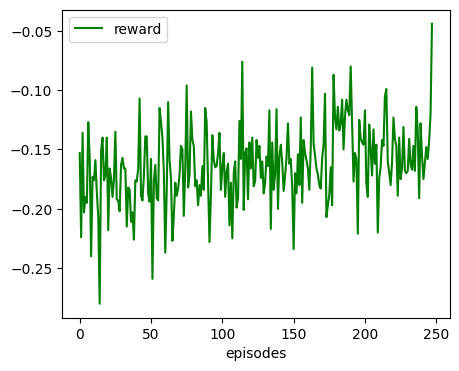

In [73]:
# Plot loss and accuracy
def plot_graphs(log_history, log_labels, graph_labels, graph_colors=['b-','g-']):
    num_graphs = len(log_labels)
    plt.figure(figsize=(5*num_graphs,4))
    for i in range(num_graphs):
        plt.subplot(1,num_graphs,i+1)
        plt.plot(log_history[log_labels[i]], graph_colors[i], label=graph_labels[i])
        plt.xlabel('episodes')
        plt.legend()
    plt.show()
    return

# Configuration for plotting
log_labels    = ['rewards']
label_strings = ['reward']
label_colors  = ['g-']
plot_graphs(history, log_labels, label_strings, label_colors)

### Evaluate the Agent

Evaluate the agent here to show the performance

In [74]:
# Evaluate the policy over multiple episodes and calculate the average reward
evaluate_episodes = 20
sum_episode_rewards = 0.0
pbar = tqdm(range(evaluate_episodes))

for i in pbar:
    rewards, _, _ = evaluate_policy(env, Q_table, 1)
    sum_episode_rewards += rewards

env.close()

print('Evaluation Result:',  sum_episode_rewards/evaluate_episodes)

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation Result: -0.2


## See How The Agent Works

In [75]:
# Evaluate the policy in the selected environment and optionally record video or collect images
env = create_env()

if SELECT_ENV != 2:
    env = wrappers.RecordVideo(env, video_folder='./gym-results/', name_prefix=res_prefix)
    eval_reward, _, _ = evaluate_policy(env, Q_table, 1)
else:
    ims = []
    eval_reward, _, ims = evaluate_policy(env, Q_table, 1, ims)

print('Sample Total Reward:', eval_reward)

env.close()

Sample Total Reward: 1.0


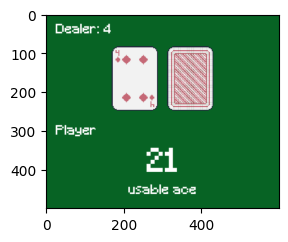

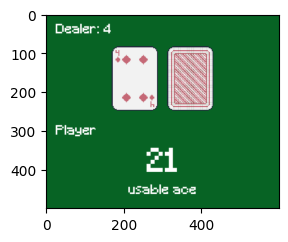

In [76]:
# Display a recorded video or render images from the evaluation depending on the environment type
from IPython.display import HTML, display
from base64 import b64encode

def show_video(video_path, video_width = 320):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

if SELECT_ENV==2:
    for i in range(len(ims)):
        plt.figure(figsize=(3,3))
        plt.imshow(ims[i])
        plt.show()
else:
    display(show_video('./gym-results/' + res_prefix + '-episode-0.mp4'))

(c) 2024 SW Lee